# Energy profile vs. beam intensity

To do: check whether the mean x and y on the BPM is the same at each intensity.

In [1]:
import os
from os.path import join
from collections import Counter
from datetime import datetime
import h5py
import numpy as np
from tqdm import trange
from scipy import optimize as opt
from matplotlib import pyplot as plt
import proplot as pplt

pplt.rc['grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'dusk_r'

In [2]:
folder = 'Diagnostics/Data/Measurements/2022-04-21/'
filenames = os.listdir(folder)
filenames = sorted(filenames, key=lambda filename: int(filename.split('-')[0]))
filenames

['220421123449-image_on_demand.h5', '220421145545-image_on_demand.h5']

In [3]:
filename = filenames[1]
file = h5py.File(join(folder, filename), 'r')
list(file.keys())

['config', 'log', 'scandata']

In [4]:
# Errors and warnings from log
for i in range(file['log'].size):
    if not(file['/log'][i, 'level'] == 'INFO'.encode('utf')):
        timestr = datetime.fromtimestamp(file['/log'][0, 'timestamp']).strftime("%m/%d/%Y, %H:%M:%S")
        print(f"{timestr} {file['log'][i, 'message']}")

# Configuration data
for key in file['/config'].keys():
    print(f"{key}")
    print("--------------")
    for name in file['/config'][key].dtype.names:
        print(f"{name}: {file['config'][key][name]}")
    print()

04/21/2022, 14:55:58 b'Ctrl-C pressed, will exit after current iteration is complete. Press Ctrl-C again to exit immediately.'
environment
--------------
timestamp: [1.65056735e+09]
user: [b'46h']
host: [b'btf-diag-app1.ics.sns.gov']
cmd_line: [b'misc/image_on_demand.py']
work_dir: [b'/home/46h/se-template']

metadata
--------------
timestamp: [1.65056736e+09]
Test_LLRF:FCM_RFQ1:CtlAmpSet: [0.63]
RFTF_TM:Gate_BeamOn:RR: [2.]
BTF_MEBT_Mag:PS_QH01:I_Set: [157.94]
BTF_MEBT_Mag:PS_QV02:I_Set: [280.06]
BTF_MEBT_Mag:PS_QH03:I_Set: [6.75]
BTF_MEBT_Mag:PS_QV04:I_Set: [-3.75]
BTF_MEBT_Mag:PS_QH05:I_Set: [0.]
BTF_MEBT_Mag:PS_QV06:I_Set: [-0.]
BTF_MEBT_Mag:PS_QV07:I_Set: [-3.1]
BTF_MEBT_Mag:PS_QH08:I_Set: [4.1]
BTF_MEBT_Mag:PS_QV09:I_Set: [-1.85000002]
BTF_MEBT_Mag:PS_QV10:I_Set: [-1.9]
BTF_MEBT_Mag:PS_QH11:I_Set: [7.2]
BTF_MEBT_Mag:PS_QV12:I_Set: [-6.55]
BTF_MEBT_Mag:PS_QH13:I_Set: [6.00035858]
BTF_MEBT_Mag:PS_QH33:I_Set: [5.1]
BTF_MEBT_Mag:PS_QV34:I_Set: [-5.3]
BTF_MEBT_Mag:PS_DCH01:I_Set: [4.7

In [5]:
data = file['scandata']
print('Data:')
for i, name in enumerate(data.dtype.names):
    print(f'{name} [{data.dtype[i]}]')
print()

slits = [key for key in data.dtype.names if 'PositionSync' in key]
print('slits:')
for slit in slits:
    print(slit)

Data:
timestamp [float64]
iteration [int64]
bcm [float64]
cam06_Image [('<i4', (313344,))]
cam06_ProfileX [('<f4', (612,))]
cam06_Saturation [float64]
ITSF_Diag:Slit_VT04:PositionSync [float64]
ITSF_Diag:Slit_VT06:PositionSync [float64]
ITSF_Diag:Slit_HZ06:PositionSync [float64]
bpm04x [('<f8', (1200,))]
bpm04y [('<f8', (1200,))]
cam06_exp [int32]
focus2 [float64]
focus1 [float64]
x_PositionSync [float64]

slits:
ITSF_Diag:Slit_VT04:PositionSync
ITSF_Diag:Slit_VT06:PositionSync
ITSF_Diag:Slit_HZ06:PositionSync
x_PositionSync


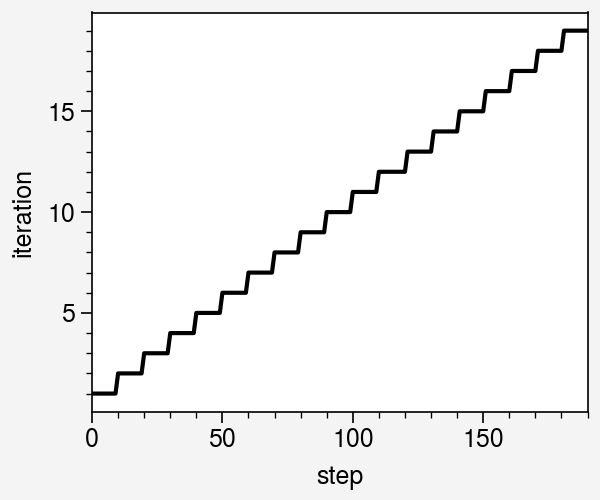

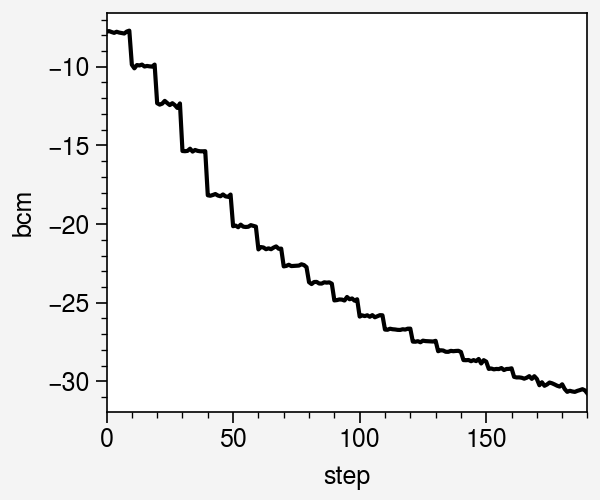

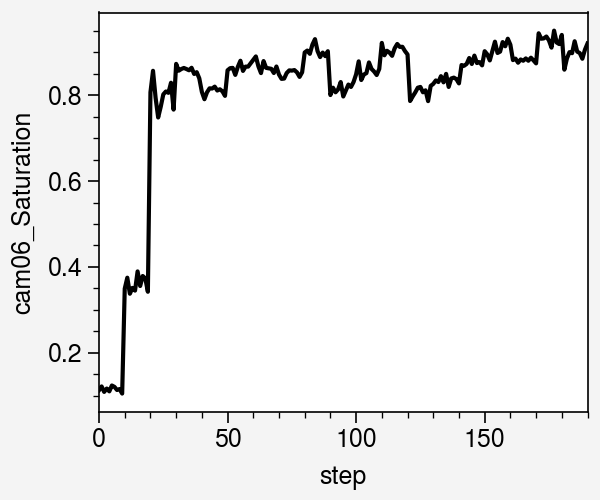

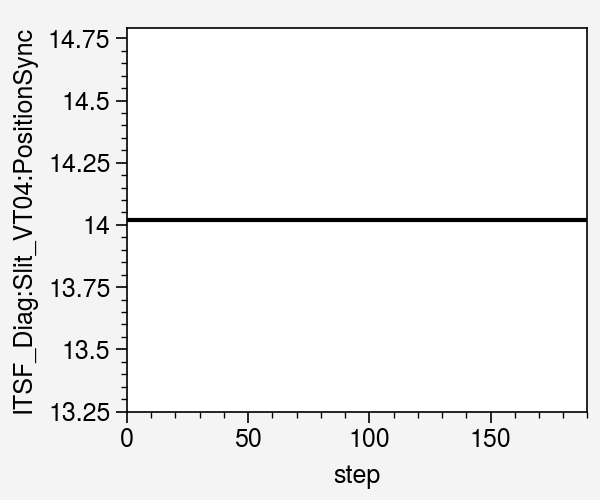

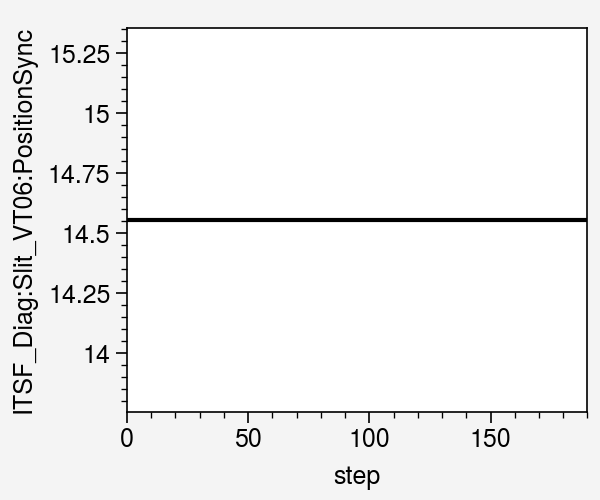

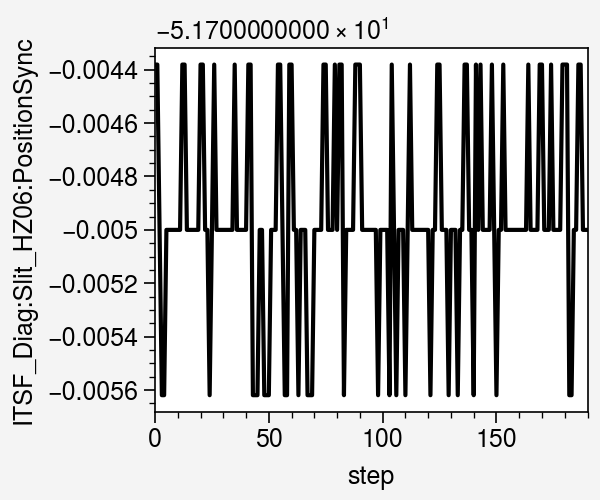

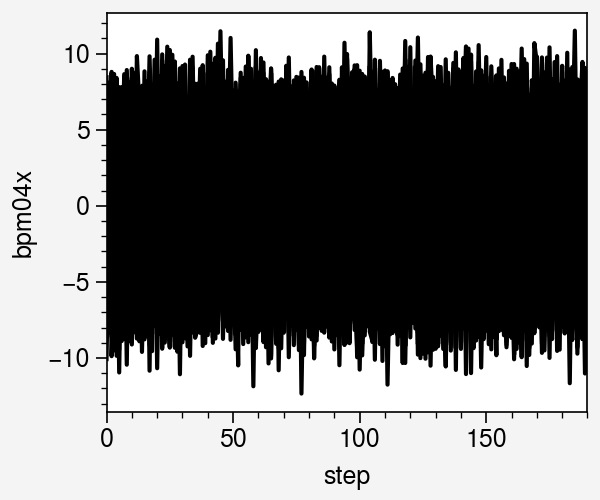

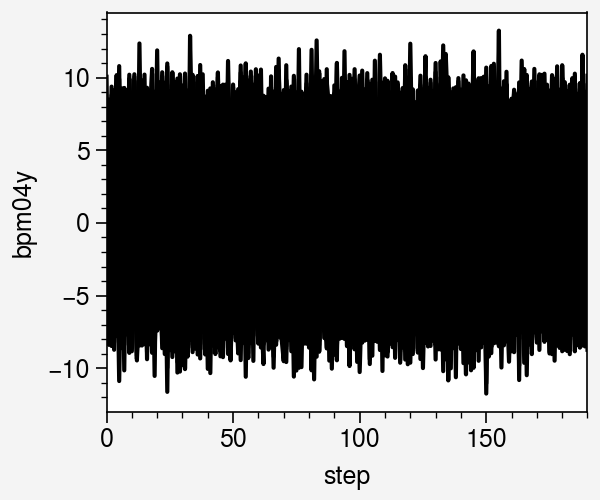

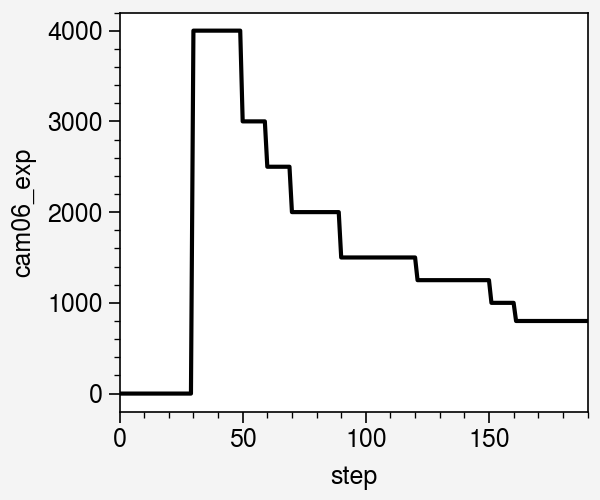

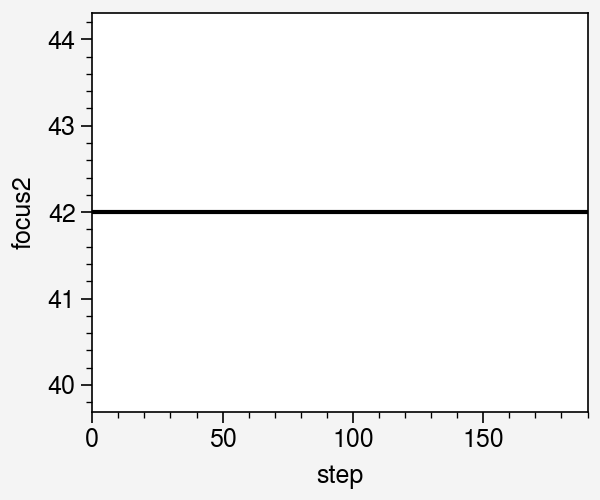

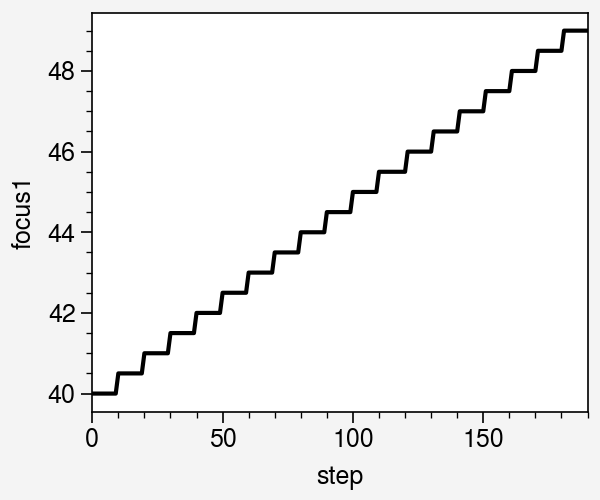

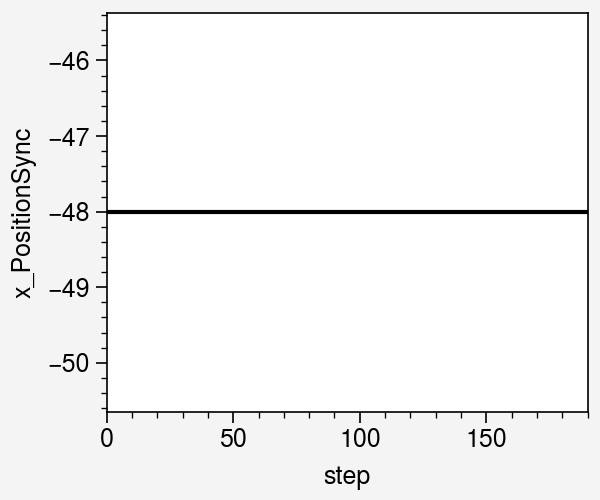

In [6]:
for name in data.dtype.names:
    if name in ['timestamp', 'cam06_Image', 'cam06_ProfileX']:
        continue
    fig, ax = pplt.subplots(figsize=(3.0, 2.5))
    ax.plot(data[name], color='black')
    ax.format(xlabel='step', ylabel=name)
    plt.show()

{'ycolor': 'grey'}


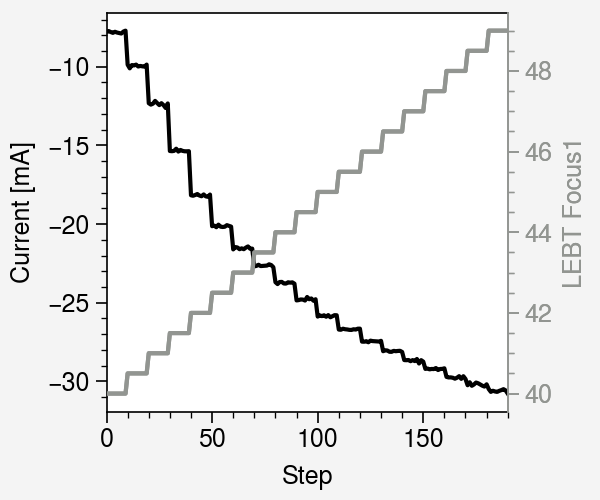

In [7]:
fig, ax = pplt.subplots(figsize=(3.0, 2.5))
ax.format(xlabel='Step', ylabel='Current [mA]')
ax2 = ax.alty(color='grey')
ax2.format(ylabel='LEBT Focus1')
ax2.plot(data['focus1'], color='grey')
ax.plot(data['bcm'], color='black')
plt.savefig('_output/current')

In [112]:
iterations = []
profiles = []
currents = []
images = []
bpmx_wfs, bpmy_wfs = [], []
bpmx_mean, bpmy_mean = [], []
bpmx_std, bpmy_std = [], []
lo, hi = 566, 595
for iteration in trange(1, max(data['iteration']) + 1):
    iterations.append(iteration)
    idx = data['iteration'] == iteration
    image = np.mean(data['cam06_Image'][idx, :], axis=0).reshape((512, 612))
    images.append(image)
    profile = np.mean(data['cam06_ProfileX'][idx, :], axis=0)  # averagine
    profile = profile / np.sum(profile)  # normalize
    profiles.append(profile)
    currents.append(data['bcm'][idx][0])
    bpmx_wf = np.mean(data['bpm04x'][idx, :], axis=0)
    bpmy_wf = np.mean(data['bpm04y'][idx, :], axis=0)
    bpmx_wfs.append(bpmx_wf)
    bpmy_wfs.append(bpmy_wf)
    bpmx_mean.append(np.mean(bpmx_wf[lo:hi]))
    bpmy_mean.append(np.mean(bpmy_wf[lo:hi]))
    bpmx_std.append(np.std(bpmx_wf[lo:hi]))
    bpmy_std.append(np.std(bpmy_wf[lo:hi]))
profiles = np.array(profiles)
currents = np.array(currents)
bpmx_wfs = np.array(bpmx_wfs)
bpmy_wfs = np.array(bpmy_wfs)

100%|██████████| 19/19 [00:07<00:00,  2.39it/s]


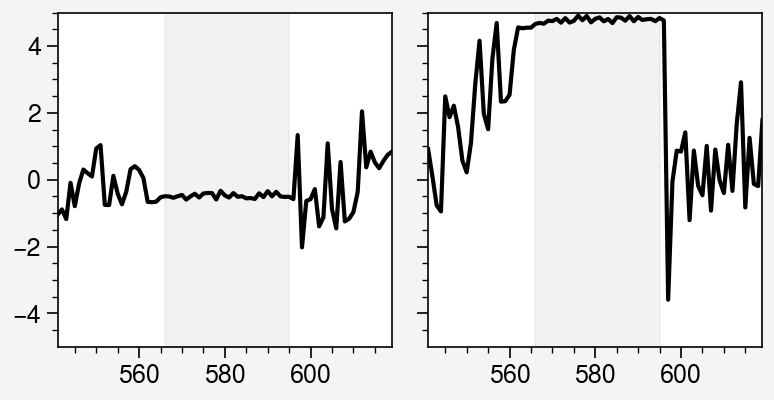

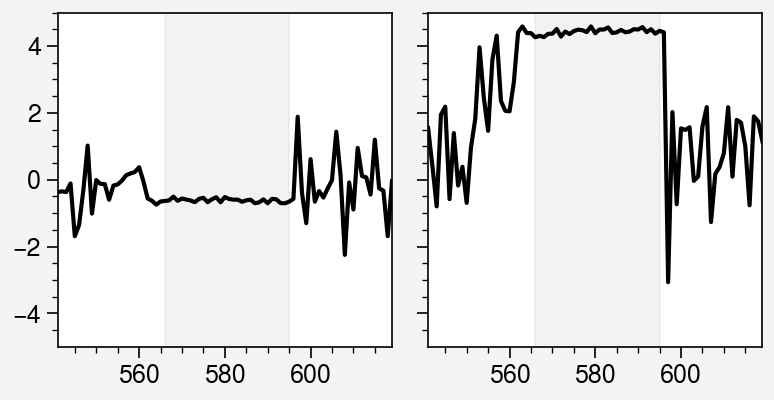

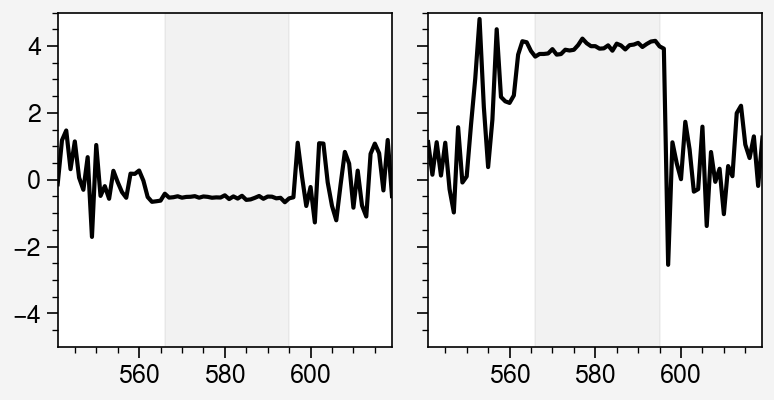

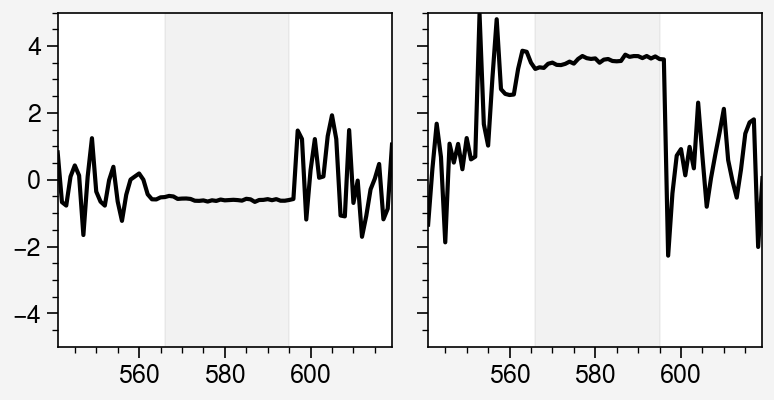

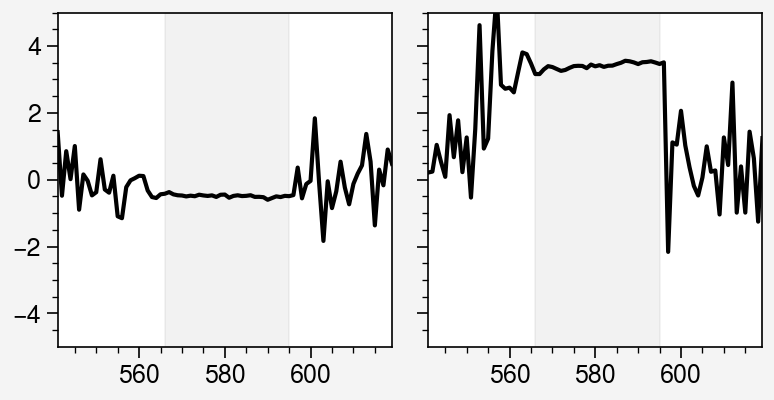

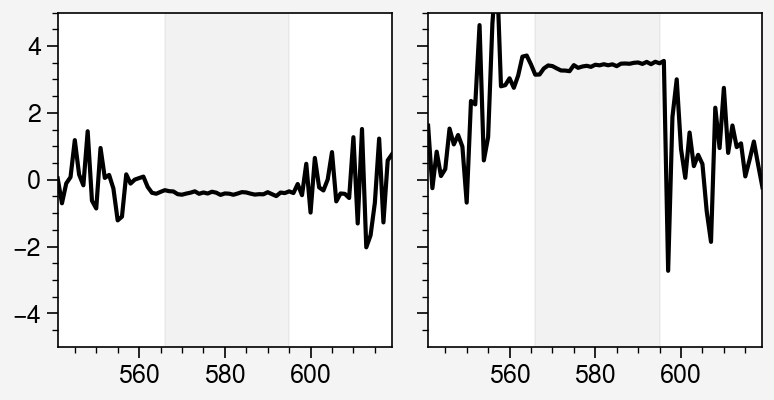

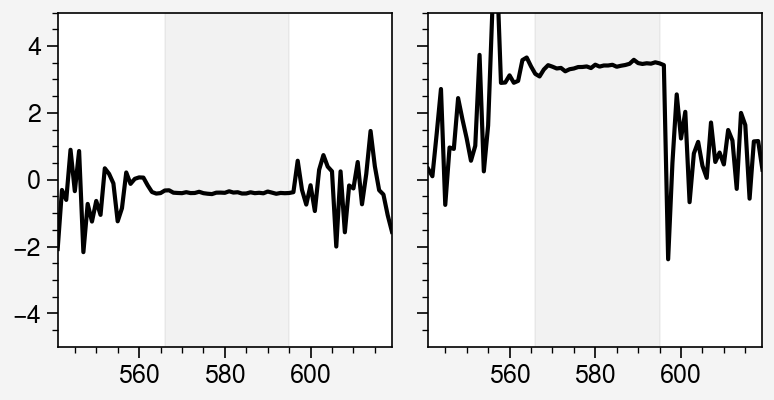

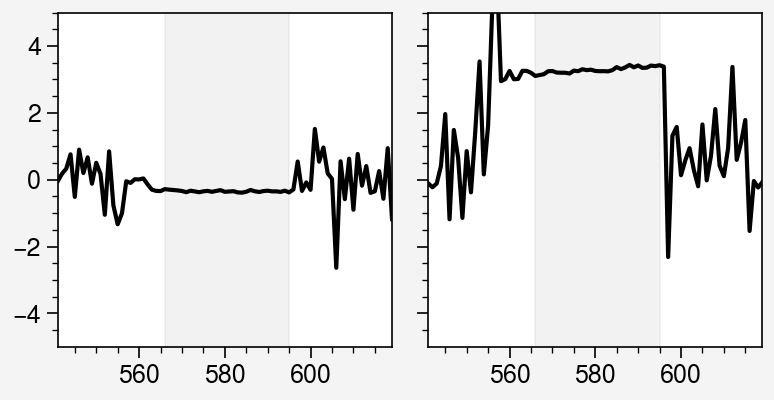

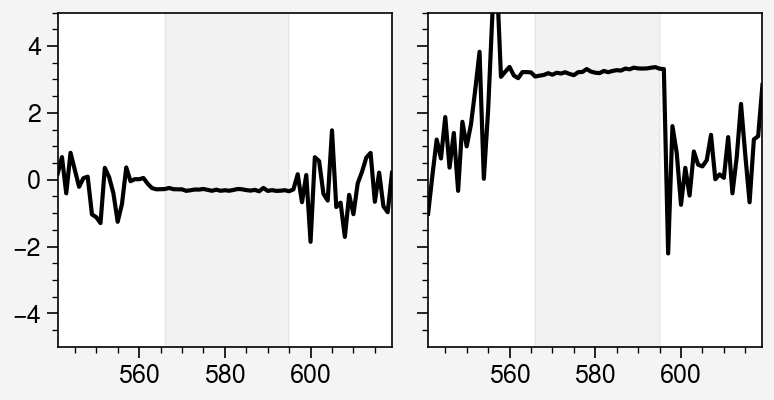

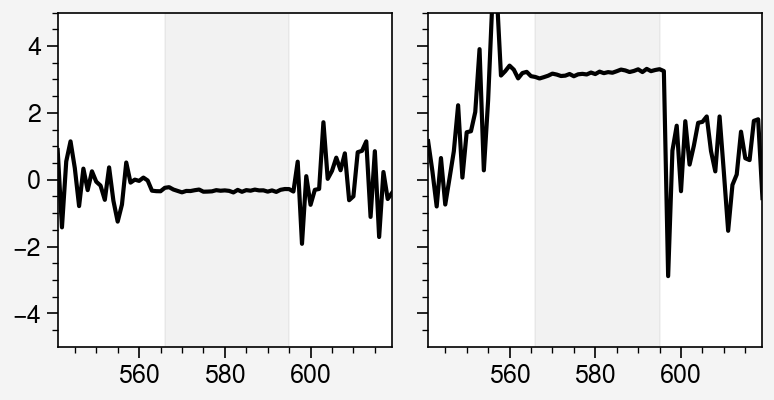

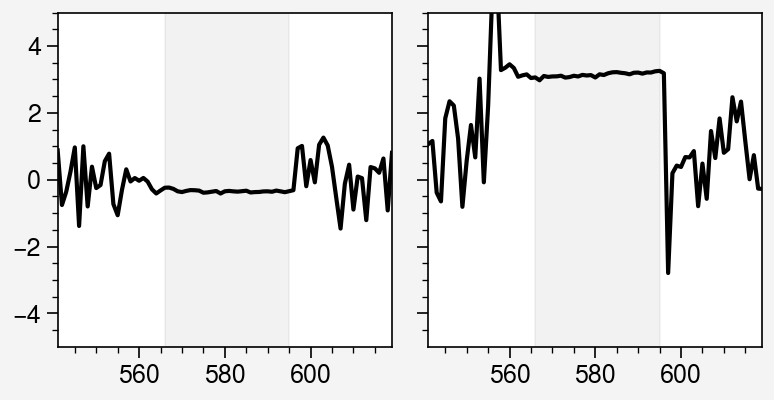

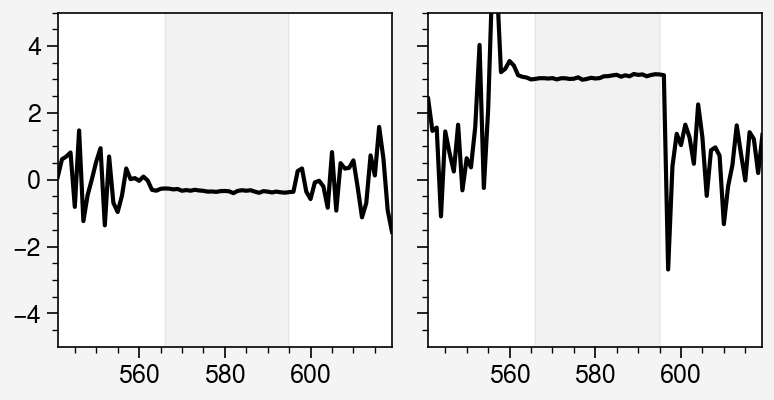

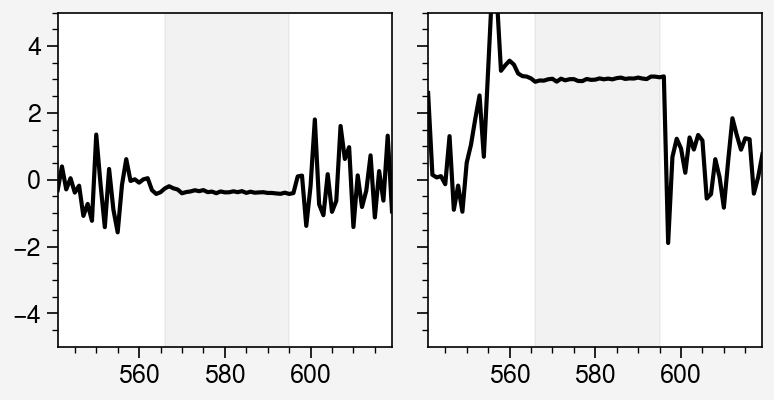

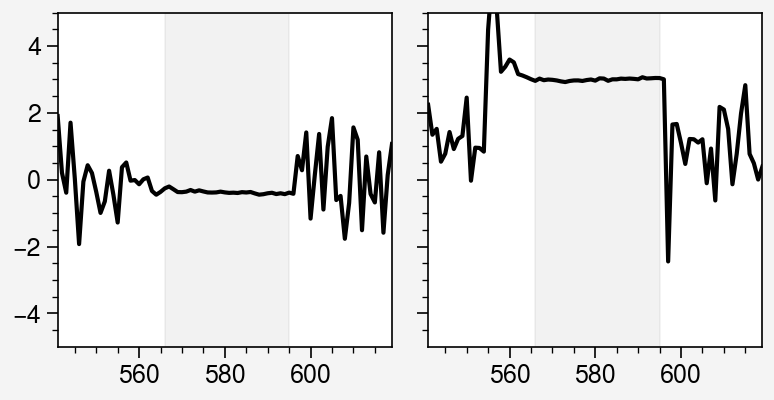

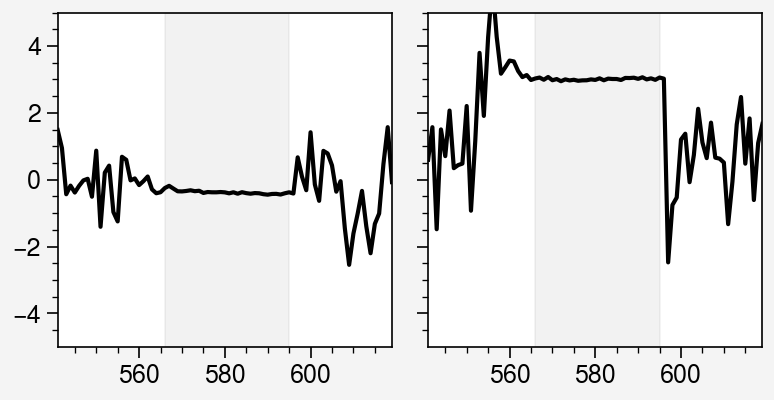

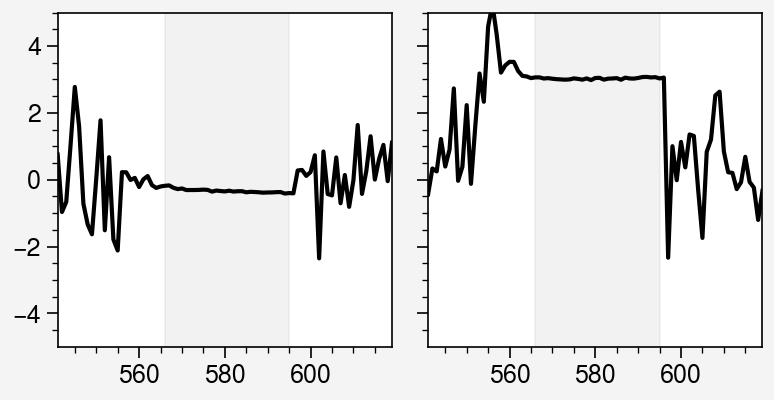

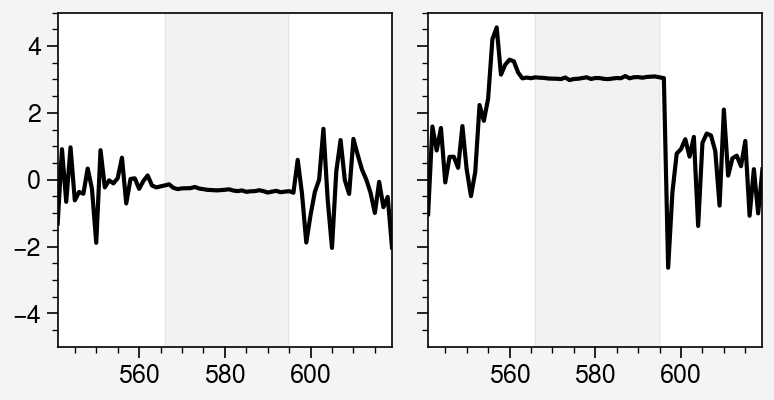

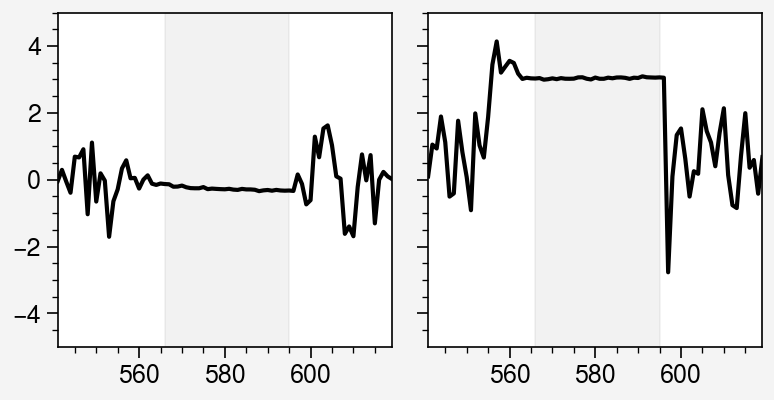

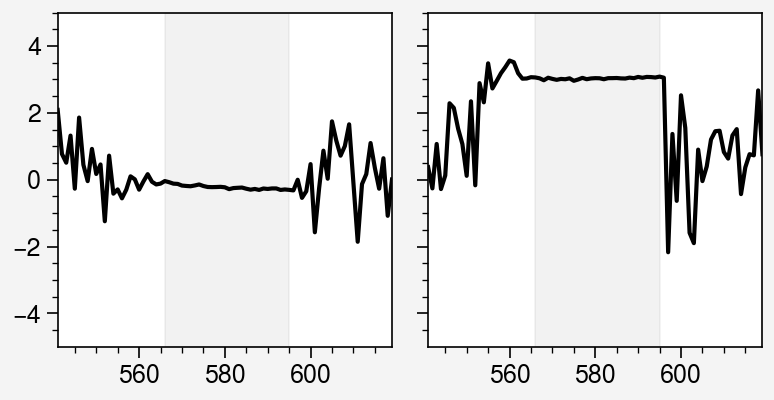

In [115]:
pad = 25
xx = np.arange(lo - pad, hi + pad)
for i in range(len(bpmx_wfs)):
    fig, axes = pplt.subplots(ncols=2, figheight=2.0)
    plot_kws = dict(color='black')
    axes[0].plot(xx, bpmx_wfs[i, lo-pad:hi+pad], **plot_kws)
    axes[1].plot(xx, bpmy_wfs[i, lo-pad:hi+pad], **plot_kws)
    for ax in axes:
        ax.axvspan(lo, hi, color='black', alpha=0.05)
    axes.format(ylim=(-5.0, 5.0))
    plt.show()

In [219]:
norm = colors.Normalize(np.min(np.abs(currents)), np.max(np.abs(currents)))
# mappable = cm.ScalarMappable(norm, pplt.Colormap('mono', left=0.05 ,right=0.89))
mappable = cm.ScalarMappable(norm, pplt.Colormap('greys', left=0.12, right=0.9))

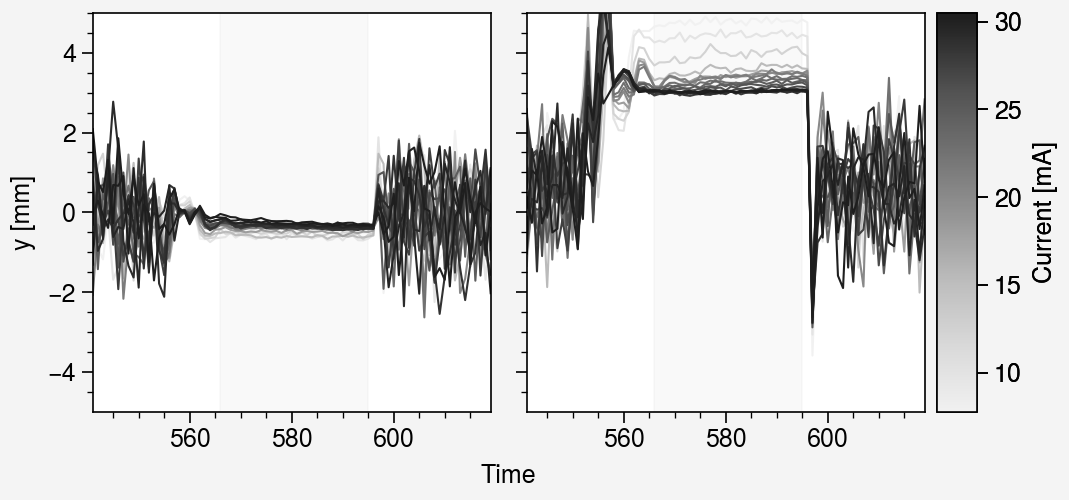

In [233]:
fig, axes = pplt.subplots(ncols=2, figheight=2.5)
plot_kws = dict(lw=0.75)
for i in range(len(bpmx_wfs)):
    axes[0].plot(xx, bpmx_wfs[i, lo-pad:hi+pad].T, color=mappable.to_rgba(np.abs(currents[i])), **plot_kws)
    axes[1].plot(xx, bpmy_wfs[i, lo-pad:hi+pad].T, color=mappable.to_rgba(np.abs(currents[i])), **plot_kws)
for ax in axes:
    ax.axvspan(lo, hi, color='black', alpha=0.025)
axes[1].colorbar(mappable, label='Current [mA]')
axes.format(ylim=(-5.0, 5.0))
axes[0].format(xlabel='Time', ylabel='x [mm]')
axes[1].format(xlabel='Time', ylabel='y [mm]')
plt.savefig('_output/bpm')

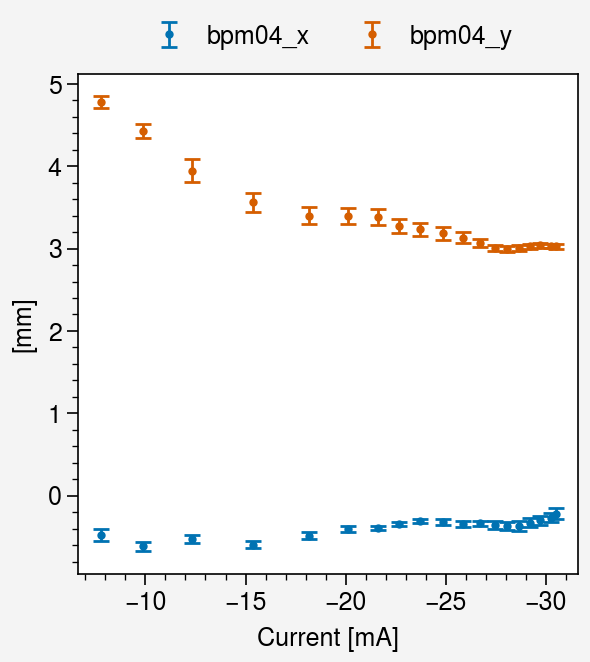

In [229]:
fig, ax = pplt.subplots()
plot_kws = dict(marker='.', ms=4.0, lw=0, elinewidth=1.0)
ax.errorbar(currents, bpmx_mean, yerr=bpmx_std, label='bpm04_x', **plot_kws)
ax.errorbar(currents, bpmy_mean, yerr=bpmy_std, label='bpm04_y', **plot_kws)
ax.format(xlabel='Current [mA]', ylabel='[mm]')
ax.legend(loc='top', framealpha=0.)

# handles, labels = ax.get_legend_handles_labels()
# # remove the errorbars
# handles = [h[0] for h in handles]
# # use them in the legend
# ax.legend(handles, labels, loc='upper left',numpoints=1)
plt.savefig('_output/bpmavg')
plt.show()

In [136]:
offsets = [i * 0.25e-2 for i in range(profiles.shape[0])]
offsets = np.array(offsets)

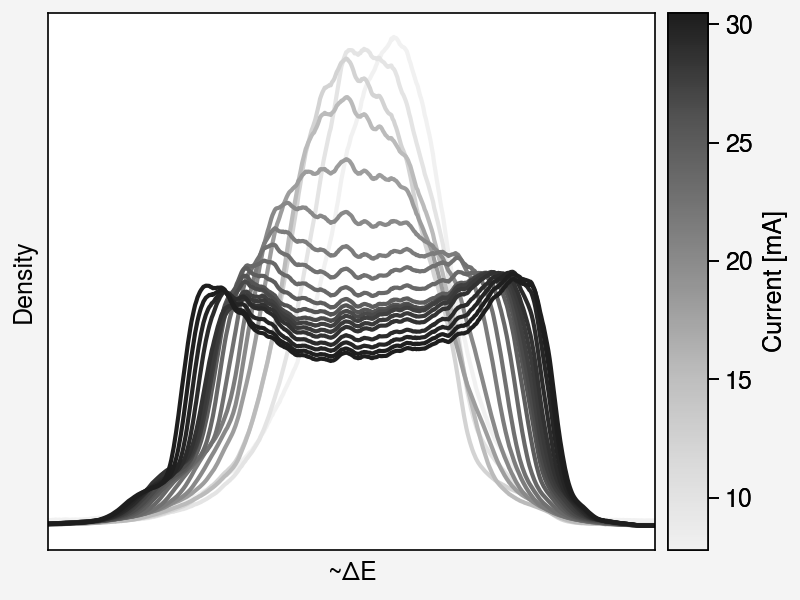

In [224]:
from matplotlib import colors
from matplotlib import cm

norm = colors.Normalize(np.min(np.abs(currents)), np.max(np.abs(currents)))
# mappable = cm.ScalarMappable(norm, pplt.Colormap('mono', left=0.05 ,right=0.89))
mappable = cm.ScalarMappable(norm, pplt.Colormap('greys', left=0.12, right=0.9))

fig, ax = pplt.subplots(figsize=(4.0, 3.0))
for profile, current in zip(profiles, currents):
    ax.plot(profile, color = mappable.to_rgba(np.abs(current)))
ax.colorbar(mappable=mappable, label='Current [mA]')
ax.format(xlim=(100, ax.get_xlim()[1]), yticks=[], xlabel=r'~$\Delta$E', xticks=[], ylabel='Density')
plt.savefig('_output/hollow')

In [ ]:
matplotlib.cm.ScalarMappable

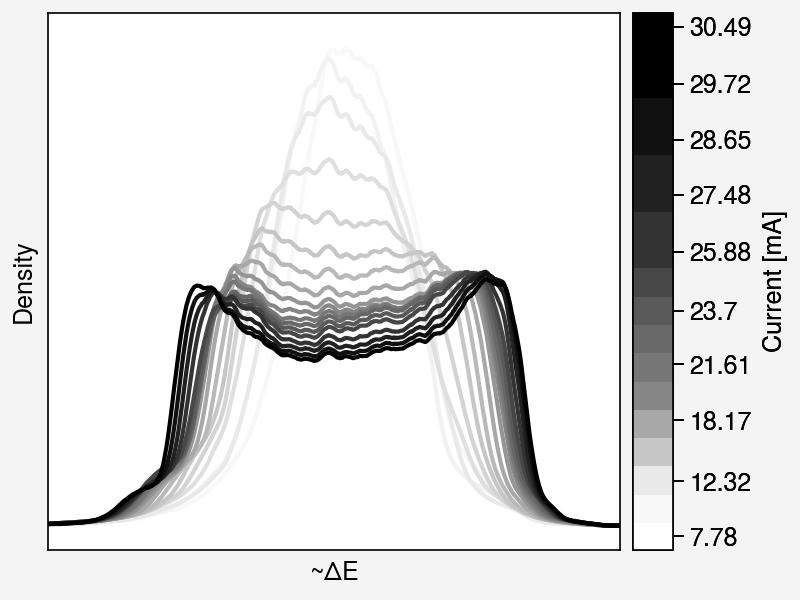

In [146]:
fig, ax = pplt.subplots(
    figsize=(4.0, 3.0)
)
ax.plot(profiles.T,
#         cycle=pplt.Colormap('greys', left=0.1, right=0.95), 
#         cycle=pplt.Colormap('mono', left=0.05, right=0.9),
        cycle='greys',
        colorbar=True, colorbar_kw=dict(label='Current [mA]',
                                        values=np.abs(currents),
                                        norm=colors.Normalize(currents[0], currents[1]),
                                        
                                       ))
ax.format(xlim=(100, ax.get_xlim()[1]), yticks=[], xlabel=r'~$\Delta$E', xticks=[], ylabel='Density')
plt.savefig('_output/overlay')
plt.show()

In [ ]:
fig, ax = pplt.subplots(figsize=(5.0, 2.0))
ax.pcolormesh(
    np.arange(profiles.shape[1]),
    currents, 
    profiles, 
    cmap='mono_r', colorbar=True, colorbar_kw=dict(ticks=[]),
)
ax.format(ylabel='Current [mA]', xlabel=r'~$\Delta$E')
plt.savefig('waterfall_heatmap')
plt.show()

In [ ]:
fig, axes = pplt.subplots(nrows=4, ncols=5, figwidth=7.0, space=0.5)
for ax in axes[-2:]:
    ax.axis('off')
for image, ax, current in zip(images[1:], axes, currents):
    ax.imshow(image, cmap='mono_r')
    ax.annotate(f'I = {current:.2f}', xy=(0.01, 0.01), xycoords='axes fraction',
                color='white', fontsize='small',
                verticalalignment='bottom', horizontalalignment='left')
axes.format(xticks=[], yticks=[])
plt.savefig('_output/images')
plt.show()

In [ ]:
pplt.rc['cmap.discrete'] = False

In [ ]:
import gif
gif.options.matplotlib["dpi"] = 200

@gif.frame
def plot(i):
    fig, ax = plt.subplots(figsize=(3.0, 3.0))
    ax.imshow(images[i], cmap=pplt.Colormap('mono_r', left=0.04))
    ax.annotate(f'I = {currents[i]:.2f} [mA]', xy=(0.01, 0.01), xycoords='axes fraction',
                color='white', fontsize='small',
                verticalalignment='bottom', horizontalalignment='left')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig(f'_output/folder/image{i}.png')

frames = [plot(i) for i in range(len(images))]

In [ ]:
gif.save(frames, '_output/images.gif', duration=0.25, unit="s", between="frames")